In [1]:
from sweat4science.workspace.Workspace import Workspace
from sweat4science.evaluation.sessionset import MF_sessionset as mfs
import sweat4science as s4s

import os
import numpy as np

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.models import model_from_json

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold
from s4s_rnn import utils

# import sys
# print(sys.path)

Using Theano backend.


In [2]:
workspace_folder = "/home/minh/workspace/git/rnd/session-data"
ws = Workspace(workspace_folder)
# user_name="MF83"
# experiment_name = ["running_indoor_lactate_test", "running_indoor_session_01", "running_indoor_session_03$"]
# session_number = None
# sessions = ws.get(user_name, experiment_name, session_number)
# sessions = sessions[0:3]

sessions = mfs.ICT_indoor(ws)


Using /home/minh/workspace/git/rnd/session-data as workspace dir


In [3]:
import re

for session in sessions:
    if len(re.findall("slope", str(session))) > 0:
        sessions.remove(session)
    pass

sessions = np.array(sessions)
print("\n".join(map(str, sessions)))


<session:MF83/running_indoor_session_01/20150219>
<session:MF83/running_indoor_session_01/20150304>
<session:MF83/running_indoor_session_01/20150810>
<session:MF83/running_indoor_lactate_test/20150310>
<session:MF83/running_indoor_lactate_test/20150325>
<session:MF83/running_indoor_lactate_test/20150408>
<session:MF83/running_indoor_session_03/20150303>
<session:MF83/running_indoor_session_03/20150305>
<session:MF83/running_indoor_session_03/20150812>


train_results/lstm_indoor_15step_3in_400hidden_20161104_100epoch_

Testing on:
<session:MF83/running_indoor_session_01/20150219>
MSE: 53.32769
RMSE: 7.30258


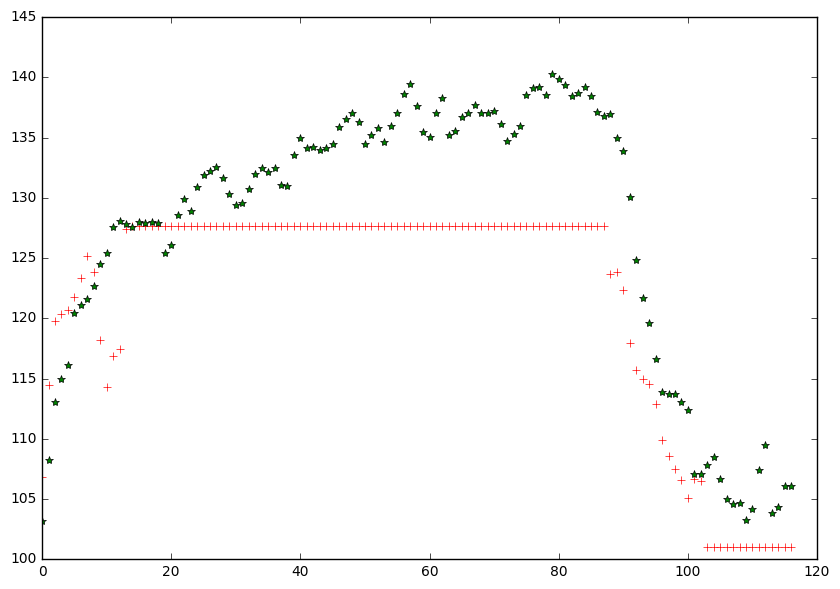


Testing on:
<session:MF83/running_indoor_session_01/20150304>
MSE: 165.67326
RMSE: 12.87141


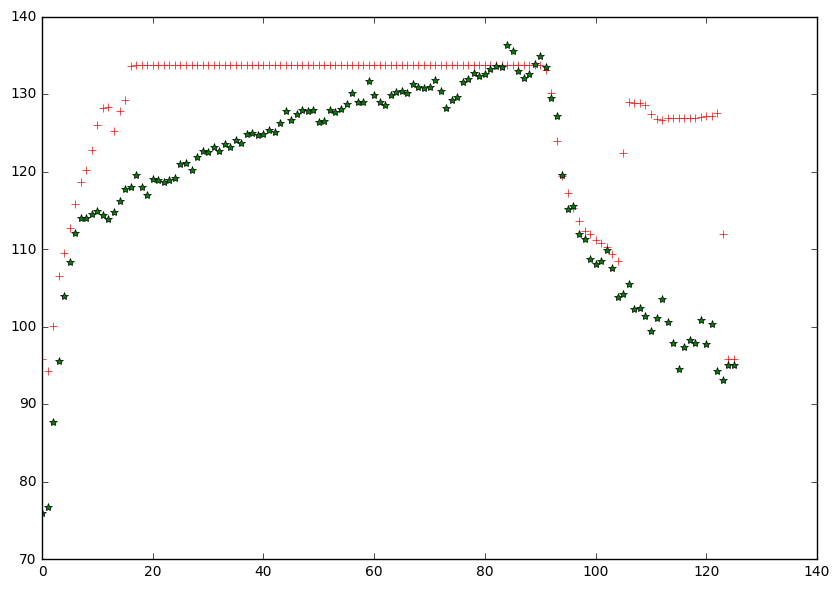


Testing on:
<session:MF83/running_indoor_session_01/20150810>
MSE: 146.13296
RMSE: 12.08855


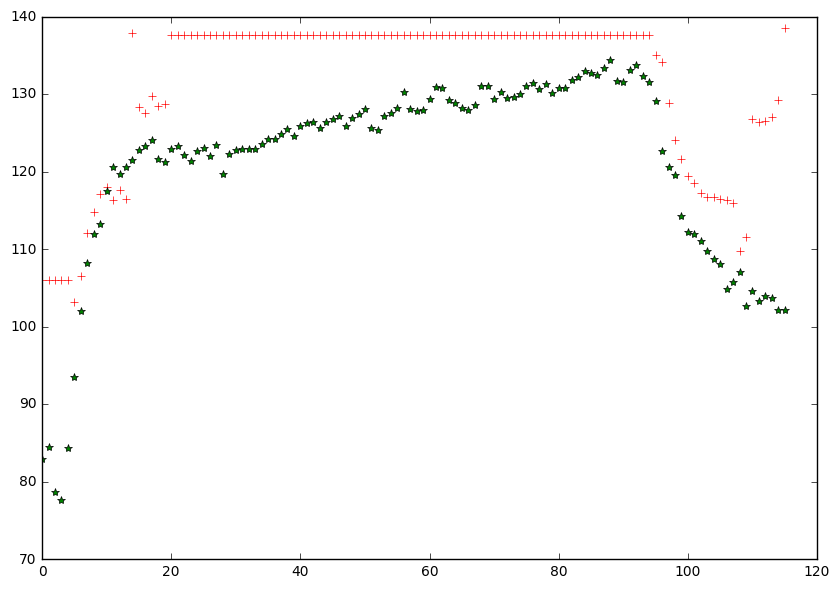


Testing on:
<session:MF83/running_indoor_lactate_test/20150310>
MSE: 198.15357
RMSE: 14.07670


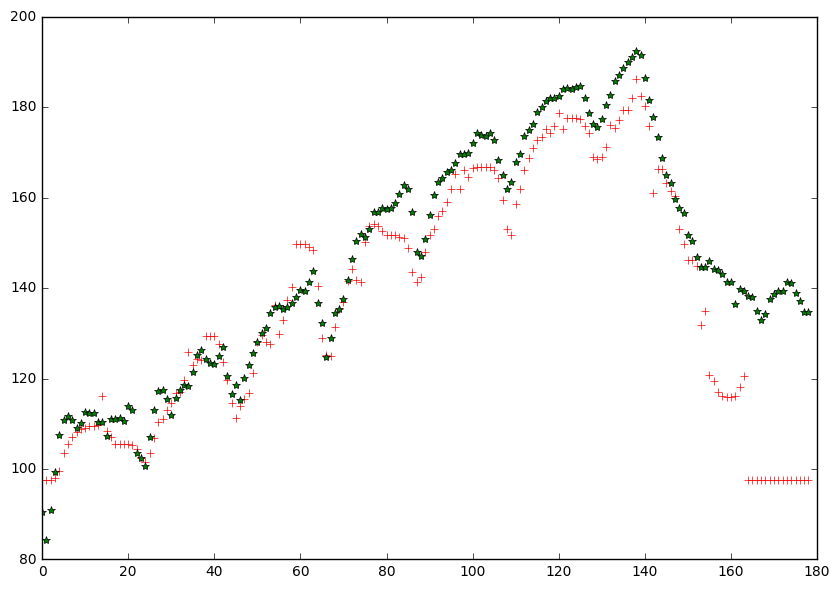


Testing on:
<session:MF83/running_indoor_lactate_test/20150325>
MSE: 93.89368
RMSE: 9.68987


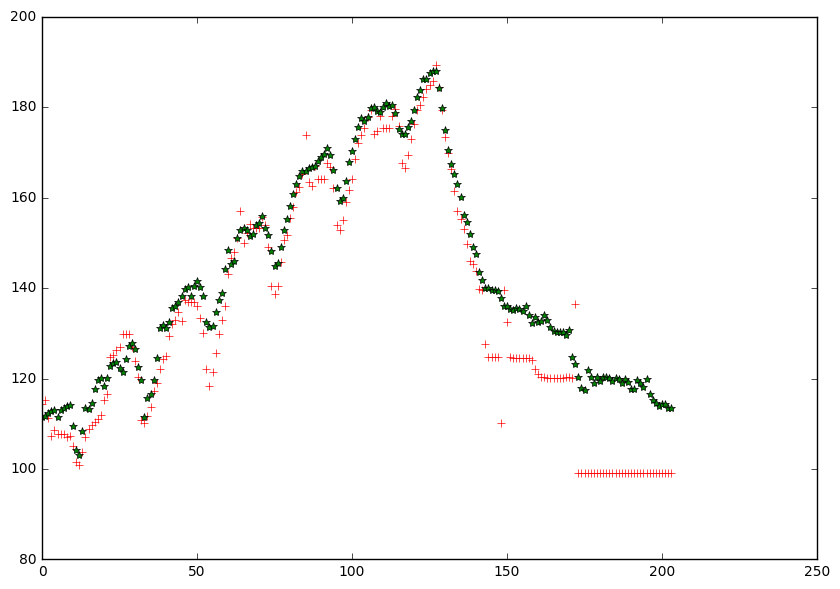


Testing on:
<session:MF83/running_indoor_lactate_test/20150408>
MSE: 117.84694
RMSE: 10.85573


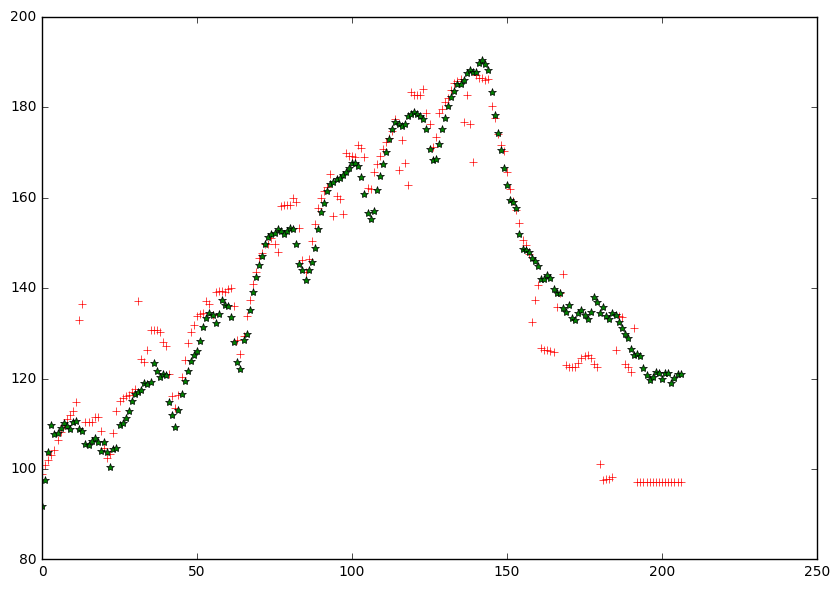


Testing on:
<session:MF83/running_indoor_session_03/20150303>
MSE: 60.32087
RMSE: 7.76665


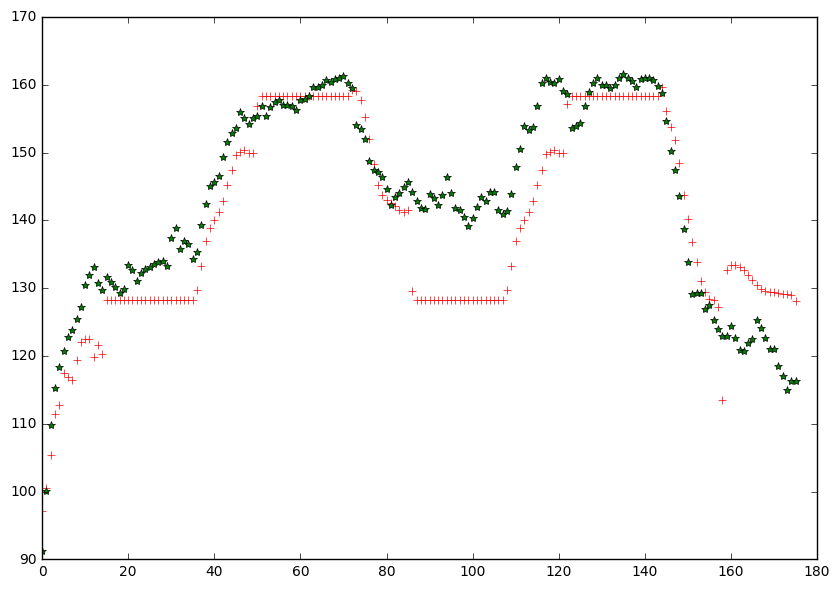


Testing on:
<session:MF83/running_indoor_session_03/20150305>
MSE: 66.06468
RMSE: 8.12802


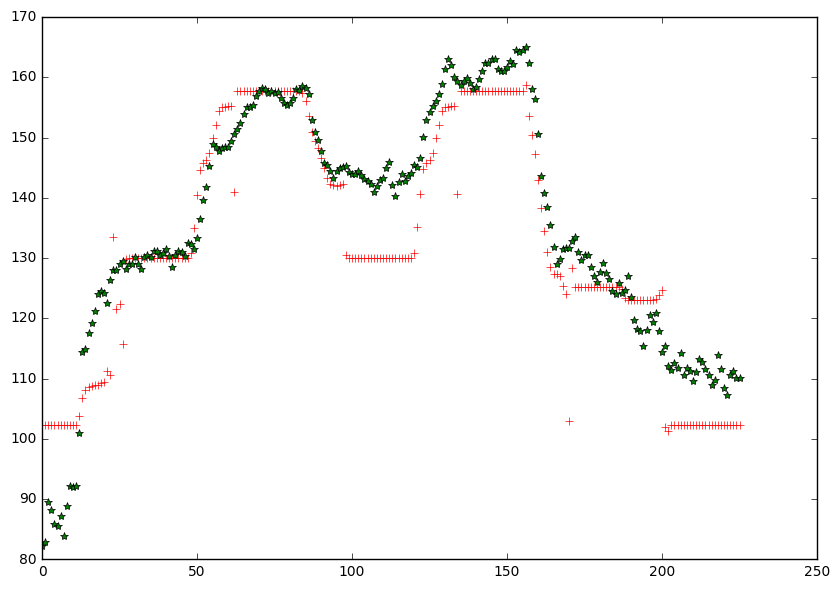


Testing on:
<session:MF83/running_indoor_session_03/20150812>
MSE: 32.62671
RMSE: 5.71198


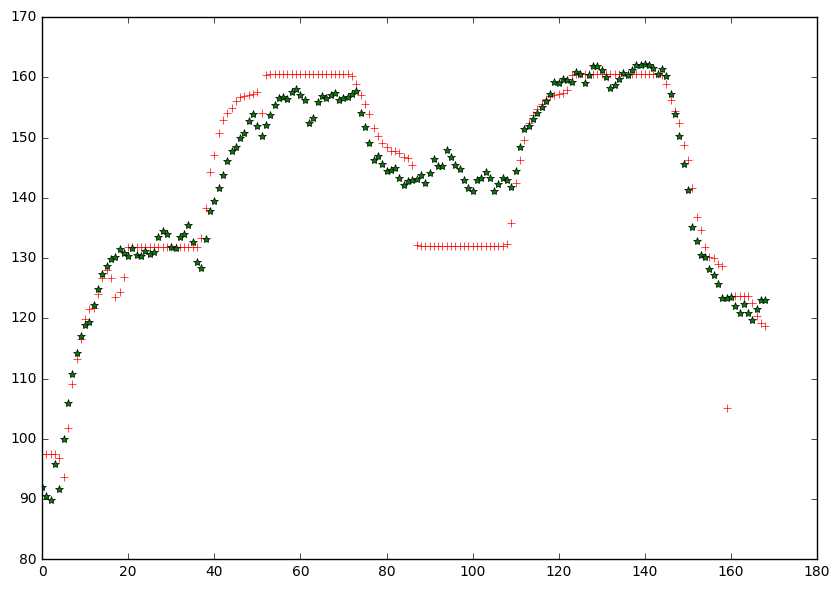

In [4]:
# Construct meaningful base name
ntsteps = 15
input_dim = 3
output_dim = 1
hidden_neurons = 400
num_epoch = 100
base_name = "lstm_indoor_" + str(ntsteps) + "step_" + str(input_dim) + "in_" + str(hidden_neurons) + "hidden_"\
            + "20161104" + "_" + str(num_epoch) + "epoch_"
base_name = os.path.join("train_results", base_name)
print(base_name)

# serialize model to JSON
model_file_name = base_name  + "model.json"
json_file = open(model_file_name, 'r')
loaded_model_json = json_file.read()
json_file.close()

# Cross validation training
test_predictions = None
test_actual_outputs = None
kf = KFold(len(sessions))
for train_index, test_index in kf.split(sessions):
    test_sessions = sessions[test_index]
    print("\nTesting on:\n" + "\n".join(map(str, test_sessions)))

    test_data_x, test_data_y = utils.get_data_from_sessions(test_sessions)
    test_data_x = utils.reshape_array_by_time_steps(test_data_x, time_steps=ntsteps)
    test_data_y = test_data_y[-len(test_data_x):]

    loaded_model = model_from_json(loaded_model_json)

    match = re.match('.+/running_indoor_(.+)/(\d+)>', str(test_sessions[0]))
    cross_validation_name = base_name + match.groups()[0] + "_" + match.groups()[1] + "_"
    loaded_model.load_weights(cross_validation_name + "weights.h5")
    loaded_model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mse'])

    test_predict = loaded_model.predict(test_data_x)
    mse = np.mean((test_predict - test_data_y)**2)
    rmse = np.sqrt(mse)
    print("MSE: %.5f\nRMSE: %.5f" % (mse, rmse) )

    test_predictions = test_predict if test_predictions is None \
        else np.append(test_predictions, test_predict, axis=0)
    test_actual_outputs = test_data_y if test_actual_outputs is None \
        else np.append(test_actual_outputs, test_data_y, axis=0)

    # Plot
    plt.figure(figsize=(10, 7))
    plt.plot(test_predict, 'r+')
    plt.plot(test_data_y, 'g*')
    plt.show()
    pass



In [5]:
# print(test_predictions.shape)
# print(test_actual_outputs.shape)

mse = np.mean((test_predictions - test_actual_outputs)**2)
rmse = np.sqrt(mse)

print("MSE: %.5f\nRMSE: %.5f" % (mse, rmse) )


MSE: 101.41100
RMSE: 10.07030
